In [279]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sys import float_info # Threshold smallest positive floating value
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(4)


In [280]:
n = 10
N_train = 50
N_test = 1000

In [281]:
# Generate Data
# Define pdfs for random variables
#np.random.seed(4)
# Draw N_train iid samples of n-dimensional samples of x
a = np.array([np.random.rand(n)]) # arbitrary non-zero n-dim vector a
x_mu = np.random.rand(n) # arbitrary non-zero mean
sigma = np.eye(n) + 0.2*np.random.rand(n,n) # arbitrary non-diagonal covariance
x_sigma = sigma.T * sigma # Force positive Semi-definite

# Define Alphas for parametric sweep
alpha = 1
# alpha_sweep = 10^(-3:0.5:3)*trace(sigma)
# alpha_plot_ind = round(1:len(alpha_sweep)/(7:len(alpha_sweep)))
# 
# Draw N_train iid samples of scalar random variable v - 0-mean, alpha-I covariance 
z_mu = np.zeros(n)
z_sigma = alpha*np.eye(n)

# Alpha Sweep Loop
# for alpha_ind in range(len(alpha_sweep)):
# 	z_sigma_sweep = alpha_sweep(alpha_ind)*eye(n)

# Draw N_train iid samples of random variable v from 0-mean, unit-variance
v_mu = 0
v_sigma = 1


# GENERATE DATA
# Training Data
x_train = multivariate_normal.rvs(x_mu,x_sigma,N_train)
z_train = multivariate_normal.rvs(z_mu,z_sigma,N_train)
v_train = v_mu+v_sigma*np.random.randn(N_train,1)

# This is the training dataset
y_train = (a.dot(x_train.T+z_train.T)).T + v_train
          

# Test Data
x_test = multivariate_normal.rvs(x_mu,x_sigma,N_test)
z_test = multivariate_normal.rvs(z_mu,z_sigma,N_test)
v_test = v_mu+v_sigma*np.random.randn(N_test,1)

y_test = (a.dot(x_test.T+z_test.T)).T + v_test


In [282]:
def mapParamEstimate(x,y,param,sigma):
    # (xT * X + gamma * I)^-1 * xT * y
    x_tilde = np.vstack((np.ones(x.shape[0]), x.T))
    w_hat = np.linalg.inv(x_tilde.dot(x_tilde.T) + sigma**2/param*np.eye(x_tilde.shape[0])).dot(x_tilde).dot(y)
    return w_hat

def meanSquaredError(w, x, y):
    N = len(y)
    x_tilde = np.vstack((np.ones(x.shape[0]), x.T))
    error = (y-x_tilde.T.dot(w))**2
    mse = np.sum(error)/N
    return mse

In [283]:
# Setup K fold cross-validation to find optimal hyperparam Beta
k = 5
beta = 1 #np.logspace(-4,3)

# x_a = np.vstack((np.ones(x_train.shape[0]), x_train.T))
# w_hat = np.linalg.inv(x_a.dot(x_a.T) + v_sigma**2/beta*np.eye(x_a.shape[0])).dot(x_a).dot(y_train)

w_hat1 = mapParamEstimate(x_train,y_train,beta,v_sigma)

In [284]:
# Use MAP Parameter estimation to determine the optimal weights for this model
betas = np.geomspace(10**-4,10**4,17)
w_maps = np.array([mapParamEstimate(x_train,y_train,beta,v_sigma) for beta in betas])
mse_map = np.array([meanSquaredError(w_map, x_test, y_test) for w_map in w_maps])
print("Mean Squared Error - MAP Estimator:\n",mse_map)
# print("Gamma Values:\n",gammas)
print("condition: ", np.linalg.cond(x_train.T.dot(x_train)))

Mean Squared Error - MAP Estimator:
 [19.79627673 18.66808056 15.97030809 11.67505105  8.02802263  6.45213126
  6.28652132  6.5113357   6.66081364  6.72035247  6.7406294   6.74719482
  6.7492866   6.74994965  6.75015949  6.75022586  6.75024685]
condition:  9.466270283143578


In [285]:
# Define Alphas for parametric sweep
alpha = 1
alpha_sweep = np.logspace(-3,3)*np.trace(x_sigma)/n
# alpha_plot_ind = round(1:len(alpha_sweep)/(7:len(alpha_sweep)))
# 
# Draw N_train iid samples of scalar random variable v - 0-mean, alpha-I covariance 
z_mu = np.zeros(n)
z_sigma = alpha*np.eye(n)
z_train = multivariate_normal.rvs(z_mu,z_sigma,N_train)

alpha_sweep = [0.01,0.1,1,10,100]
# alpha_sweep = [1]
y_train_sweep = []
# Alpha Sweep Loop
for alpha_ind in range(len(alpha_sweep)):
    z_sigma_sweep = alpha_sweep[alpha_ind]*np.eye(n)
    # z_sigmas.append(z_sigma_sweep)
    z_trains = multivariate_normal.rvs(z_mu,z_sigma_sweep,N_train)
    y_train_sweep.append((a.dot(x_train.T+z_trains.T)).T + v_train)

# This is the training dataset


In [286]:
# # Negative Log Likelihood (NLL) loss
# def ll_loss(parameters, X, y, sigma=1):
#     mu_pred = X.dot(parameters)
    
#     # Compute log-likelihood function, setting mu=0 as we're estimating it
#     log_lld = np.sum(multivariate_normal.pdf(y - mu_pred, 0, sigma))
    
#     # Return NLL
#     return log_lld

# # Adding PSD constraints on sigma
# # def constraints(parameters):
# #     sigma = parameters[2]
# #     return sigma

# # cons = {
# #     'type': 'ineq',
# #     'fun': constraints
# # }

# # Minimize NLL instead, assuming fixed variance of 1
# sigma = 1
# mle_model = minimize(nll_loss, theta0, args=(X, y, sigma), tol=1e-6)#, constraints=cons)

Optimal Beta =  1.0
Optimal Beta =  0.19306977288832497
Optimal Beta =  0.05179474679231207
Optimal Beta =  0.01
Optimal Beta =  0.005179474679231213


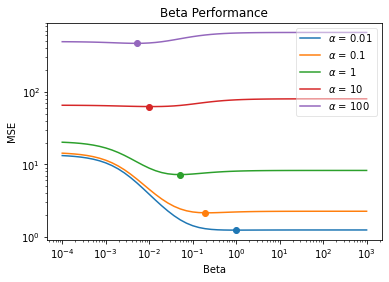

In [287]:
betas = np.logspace(-4,3) # 50 Beta vals to try from 1e-4 to 1e3 
cv = KFold(n_splits=5, shuffle=True) # Setup KFold with 5 folds
mse_map = np.empty((50, 5)) # Allocate space for matrix of MSEs

plt.figure()
alpha_ind = 0
beta_opts = []
# Perform Cross-Validation
for y_train in y_train_sweep:
    # y_train = (a.dot(x_train.T+z_train.T)).T + v_train

    for fold, (train_indices, valid_indices) in enumerate(cv.split(x_train)):
        # Extract the training and validation sets from the K-fold split
        X_train_k = x_train[train_indices]
        y_train_k = y_train[train_indices]
        X_valid_k = x_train[valid_indices]
        y_valid_k = y_train[valid_indices]    

        # Find Parameter Vector using MAP equation for each fold and for each value of beta
        w_maps = np.array([mapParamEstimate(X_train_k,y_train_k,beta,v_sigma) for beta in betas])
        # Find the MSE for each generated param vector using validation set
        mse_map[:,fold] = np.array([meanSquaredError(w_map, X_valid_k, y_valid_k) for w_map in w_maps])

    # Average across each fold - results in MSE averaged estimate for each Beta value
    avgs = [np.average(mse_map[i,:]) for i in range(mse_map.shape[0])]

    beta_opt = betas[avgs.index(np.min(avgs))]
    beta_opts.append(beta_opt)
    print("Optimal Beta = ", beta_opt)
    alpha_val = alpha_sweep[alpha_ind]
    


    # TURN THIS INTO TWO FIGURES!
    # plt.scatter(beta_opt,alpha_val)
    plt.scatter(beta_opt,np.min(avgs))
    plt.plot(betas,avgs,label=r"$\alpha$ = {}".format(alpha_val))
    alpha_ind = alpha_ind + 1

plt.legend(loc='best', fancybox=True, framealpha=0.5)
plt.title("Beta Performance")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Beta")
plt.ylabel("MSE")
plt.show()

Text(0, 0.5, 'Alpha')

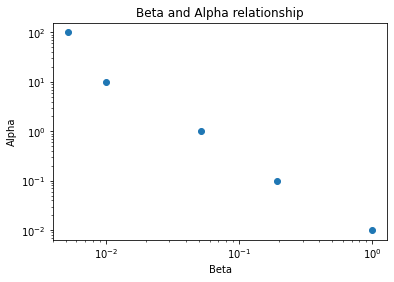

In [288]:
plt.scatter(beta_opts,alpha_sweep)
plt.title("Beta and Alpha relationship")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Beta")
plt.ylabel("Alpha")

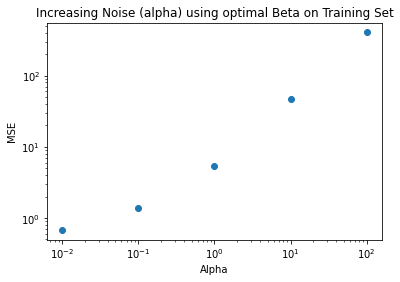

In [289]:
# Now we have trained optimal weights for sweeps of Beta and Alpha
# Use the entire training dataset to optimize the model parameters using MAP using best hyperparams


# Find Parameter Vector using MAP equation for each fold and for each value of beta
w_maps_train = np.array([mapParamEstimate(x_train,y_train_sweep[i],beta_opts[i],v_sigma) for i in range(len(beta_opts))])
# Find the MSE for each generated param vector using validation set
mse_map_train = np.array([meanSquaredError(w_maps_train[i], x_train, y_train_sweep[i]) for i in range(w_maps_train.shape[0])])
# -2 times log likelihood of TEST DATA ?????

plt.scatter(alpha_sweep,mse_map_train)
plt.title("Increasing Noise (alpha) using optimal Beta on Training Set")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Alpha")
plt.ylabel("MSE")
plt.show()


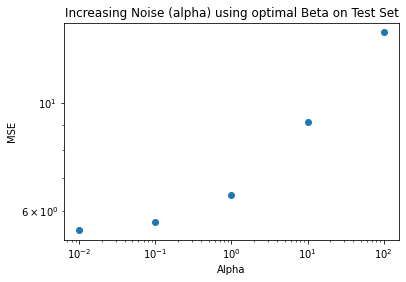

In [290]:
mse_map_train = np.array([meanSquaredError(w_map, x_test, y_test) for w_map in w_maps_train])
# -2 times log likelihood of TEST DATA ?????

plt.scatter(alpha_sweep,mse_map_train)
plt.title("Increasing Noise (alpha) using optimal Beta on Test Set")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Alpha")
plt.ylabel("MSE")
plt.show()

In [291]:
def meanSquaredError(w, x, y):
    N = len(y)
    x_tilde = np.vstack((np.ones(x.shape[0]), x.T))
    error = (y-x_tilde.T.dot(w))**2
    mse = np.sum(error)/N
    return mse

# Negative Log Likelihood (NLL) loss
def nll_loss(w, X, y, sigma=1):
    x_tilde = np.vstack((np.ones(X.shape[0]), X.T))
    error = (y-x_tilde.T.dot(w))
    # Compute log-likelihood function, setting mu=0 as we're estimating it
    log_lld = np.sum(np.log(multivariate_normal.pdf(error, 0, sigma)))
    
    # Return NLL
    return log_lld

Optimal Beta =  0.0001
Optimal Beta =  0.0001
Optimal Beta =  0.0001
Optimal Beta =  1000.0
Optimal Beta =  0.0001


C:\Users\meuli\AppData\Local\Temp\ipykernel_24136\3834310229.py:13: RuntimeWarning: divide by zero encountered in log
  log_lld = np.sum(np.log(multivariate_normal.pdf(error, 0, sigma)))


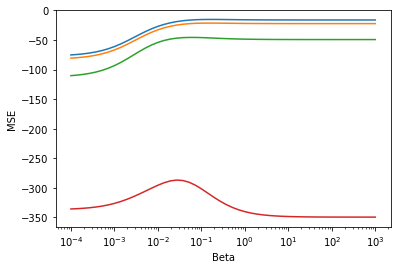

In [292]:
betas = np.logspace(-4,3) # 50 Beta vals to try from 1e-4 to 1e3 
cv = KFold(n_splits=5, shuffle=True) # Setup KFold with 5 folds
mse_map = np.empty((50, 5)) # Allocate space for matrix of MSEs

plt.figure()
alpha_ind = 0
beta_opts = []
# Perform Cross-Validation
for y_train in y_train_sweep:
    # y_train = (a.dot(x_train.T+z_train.T)).T + v_train
    for fold, (train_indices, valid_indices) in enumerate(cv.split(x_train)):
        # Extract the training and validation sets from the K-fold split
        X_train_k = x_train[train_indices]
        y_train_k = y_train[train_indices]
        X_valid_k = x_train[valid_indices]
        y_valid_k = y_train[valid_indices]    

        # Find Parameter Vector using MAP equation for each fold and for each value of beta
        w_maps = np.array([mapParamEstimate(X_train_k,y_train_k,beta,v_sigma) for beta in betas])
        # Find the MSE for each generated param vector using validation set
        mse_map[:,fold] = np.array([nll_loss(w_map, X_valid_k, y_valid_k) for w_map in w_maps])

    # Average across each fold - results in MSE averaged estimate for each Beta value
    avgs = [np.average(mse_map[i,:]) for i in range(mse_map.shape[0])]

    beta_opt = betas[avgs.index(np.min(avgs))]
    beta_opts.append(beta_opt)
    print("Optimal Beta = ", beta_opt)
    # alpha_val = alpha_sweep[alpha_ind]
    # alpha_ind = alpha_ind + 1


    # TURN THIS INTO TWO FIGURES!
    # plt.scatter(beta_opt,alpha_val)

    plt.plot(betas,avgs)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("Beta")
plt.ylabel("MSE")
plt.show()

C:\Users\meuli\AppData\Local\Temp\ipykernel_24136\3834310229.py:13: RuntimeWarning: divide by zero encountered in log
  log_lld = np.sum(np.log(multivariate_normal.pdf(error, 0, sigma)))


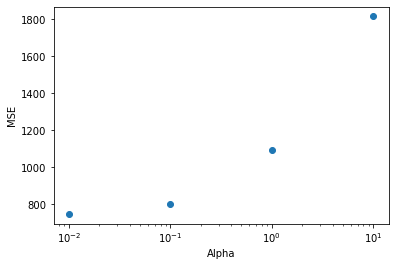

In [293]:
# Now we have trained optimal weights for sweeps of Beta and Alpha
# Use the entire training dataset to optimize the model parameters using MAP using best hyperparams


# Find Parameter Vector using MAP equation for each fold and for each value of beta
w_maps_train = np.array([mapParamEstimate(x_train,y_train_sweep[i],beta_opts[i],v_sigma) for i in range(len(beta_opts))])
# Find the MSE for each generated param vector using validation set
mse_map_train = np.array([-2*nll_loss(w_maps_train[i], x_train, y_train_sweep[i]) for i in range(w_maps_train.shape[0])])
# -2 times log likelihood of TEST DATA ?????

plt.scatter(alpha_sweep,mse_map_train)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("Alpha")
plt.ylabel("MSE")
plt.show()